### Evaluate distribution of ground control points

Working toward some metrics to quantify the GCP distribution. This calculates the distribution of GCP distances 
and the number of GCPs / m^2, based on the convex hull area.

TODO:
* Maybe dilate the convex hull area to represent the additional area covered by targets on the perimeter (shapely?)
* Normalize the area by something to take out camera affects (camera footprint? GSD^2? Altidude^2?)


In [2]:
# Evaluate GCP distribution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

dn = ".\\"
fn = "2017-04-28_GCPs.txt"
print(dn+fn)
# read in the file (in the format exported from Photoscan)
df=pd.read_csv(dn+fn,delimiter=',',skiprows=[0])
df

.\2017-04-28_GCPs.txt


,#Label,Enable,X/Easting,Y/Northing,Z/Altitude,Accuracy_X/Y/Z_(m),Error_(m),X_error,Y_error,Z_error,X_est,Y_est,Z_est
0,T18,1,377201.5432,4.624613e+06,1.6758,NaN,0.022388,0.001036,0.009889,0.020059,377201.544236,4.624613e+06,1.695859
1,T20,1,377034.3030,4.624693e+06,1.7620,NaN,0.046752,-0.041852,-0.005634,0.020059,377034.261157,4.624693e+06,1.782059
2,T19,1,377151.6261,4.624637e+06,1.1600,NaN,0.071421,-0.066701,-0.017925,-0.018184,377151.559414,4.624637e+06,1.141816
3,T17,1,377331.4144,4.624573e+06,-0.4845,NaN,0.040367,0.034440,0.013799,-0.015906,377331.448833,4.624573e+06,-0.500406
4,T16,1,377225.2911,4.624656e+06,2.5041,NaN,0.040200,0.010731,0.037140,0.011024,377225.301829,4.624656e+06,2.515124
5,T21,1,376941.3262,4.624769e+06,1.0644,NaN,0.012309,-0.002427,-0.008653,-0.008410,376941.323773,4.624769e+06,1.055990
6,T8,1,376539.5396,4.624997e+06,1.4488,NaN,0.019616,-0.019105,0.004137,-0.001640,376539.520499,4.624997e+06,1.447160
7,T14,1,377075.8505,4.624755e+06,2.3949,NaN,0.016997,0.006149,-0.014622,-0.006106,377075.856648,4.624755e+06,2.388794
8,P3,1,376537.6211,4.625135e+06,5.2726,NaN,0.048220,-0.020931,0.016746,0.040082,376537.600173,4.625135e+06,5.312682
9,T7,1,376507.8345,4.625230e+06,-0.2558,NaN,0.024304,0.010554,-0.020032,-0.008833,376507.845052,4.625230e+06,-0.264633


In [3]:
# Distance to closest neighbor
xyz = df.as_matrix(columns=df.columns[2:5])
n = len(xyz)
dist = np.zeros((n,1))
for i in np.arange(len(xyz)):
    # after sorting, index[1] is distance to closest neighbor
    dist[i]=np.sort(np.sqrt(np.sum((xyz-xyz[i,:])**2.,1)))[1] 
df['dist'] = dist

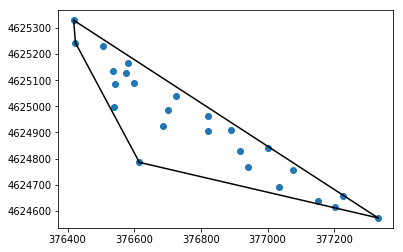

In [5]:
# determine 2D convex hull
xy = df.as_matrix(columns=df.columns[2:4])
hull = ConvexHull(xy)
plt.plot(xy[:,0], xy[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(xy[simplex, 0], xy[simplex, 1], 'k-')

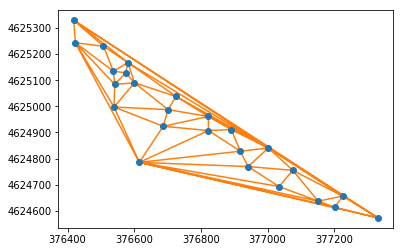

In [8]:
# Is there some metric related to the Delaunay triangulation that might help in the design of GCP layout?
tri = Delaunay(xy)
plt.plot(xy[:,0], xy[:,1], 'o')
plt.triplot(xy[:,0], xy[:,1], tri.simplices.copy())



376400.0 377400.0 4624500.0 4625400.0


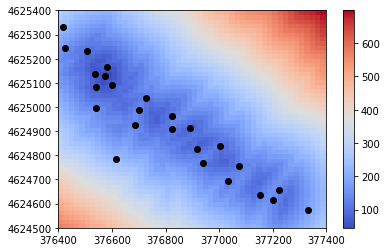

In [48]:
# What about a map or distance to the third closest point? (Since three points are required to define a plane)
# Is there any relationship between this map and the accuracy of the SfM maps?
xmin= 100.*np.floor(np.min(xy[:,0]/100.))
xmax= 100.*np.ceil(np.max(xy[:,0]/100.))
ymin= 100.*np.floor(np.min(xy[:,1]/100.))
ymax= 100.*np.ceil(np.max(xy[:,1]/100.))
print(xmin,xmax,ymin,ymax)
X,Y = np.meshgrid(np.linspace(xmin,xmax,51),np.linspace(ymin,ymax,51))
# print(X,Y)

dist3 = np.zeros_like(X)
ni,nj = np.shape(X)
nk = len(xyz)
dist2 = np.zeros(nk)
for i in range(ni):
    for j in range(nj):
       for k in range(nk):
          #print(xyz[k,0:2])
          dist2[k]= np.sqrt( np.sum((np.array([X[i,j],Y[i,j]])-xyz[k,0:2])**2, 0 ))
       # after sorting, index[1] is distance to closest neighbor
       dist3[i,j]=np.sort(dist2)[3] 

cm = plt.cm.get_cmap('coolwarm')
plt.pcolormesh(X,Y,dist3,cmap=cm)
plt.plot(xy[:,0], xy[:,1], 'ok')
plt.colorbar()

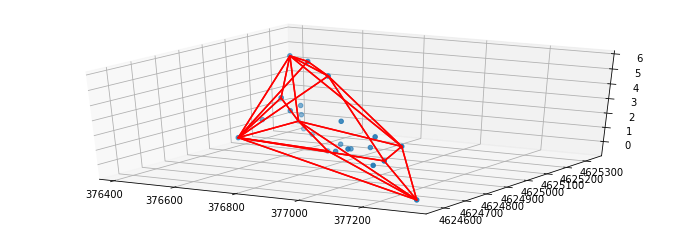

In [4]:
# determine 3D convex hull
xy = df.as_matrix(columns=df.columns[2:4])
hull3 = ConvexHull(xyz)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( xyz[:,0], xyz[:,1], xyz[:,2], marker='o')
for s in hull3.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(xyz[s, 0], xyz[s, 1], xyz[s, 2], "r-")

In [5]:
print("Elevation distribution:\n",df['Z/Altitude'].describe(),'\n')
print("Distance from nearest GCP:\n",df['dist'].describe(),'\n')
print("Area of 2D hull: ",hull.area, 'm^2',' (= ',1e-4*hull.area,' hectares, =',2.47e-4*hull.area,' acres.')
print("Average 2D hull area per GCP: ",hull.area/n, 'm^2',' (= ',1e-4*hull.area/n,' hectares, =',2.47e-4*hull.area/n,' acres.')
print("Volume of 3D hull: ",hull3.volume, 'm^3')    
print("Average 3D hull volume per GCP: ",hull3.volume/n, 'm^3')

Elevation distribution:
 count    25.000000
mean      1.727452
std       1.735774
min      -0.563300
25%       0.499500
50%       1.448800
75%       2.504100
max       5.739400
Name: Z/Altitude, dtype: float64 

Distance from nearest GCP:
 count     25.000000
mean      68.588061
std       28.015411
min       37.924662
25%       50.776621
50%       63.011069
75%       84.925154
max      155.696709
Name: dist, dtype: float64 

Area of 2D hull:  2516.095207032294 m^2  (=  0.25160952070322945  hectares, = 0.6214755161369766  acres.
Average 2D hull area per GCP:  100.64380828129177 m^2  (=  0.010064380828129178  hectares, = 0.024859020645479065  acres.
Volume of 3D hull:  540286.921419403 m^3
Average 3D hull volume per GCP:  21611.47685677612 m^3
